In [120]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from collections import Counter

# keep matplotlib interactive
# %matplotlib notebook
%matplotlib inline

# use ggplot style
plt.style.use('ggplot')

# Preface
Prior to building a model, we first need to make sure categorical data are encoded then we need to split our data into a train and test set. Because of class imbalance we will need to use upsampling (SMOTE or ADASYN) or downsampling.


In [88]:
feature_list = []

### Activity log features

In [89]:
proc_dir = os.path.join(os.pardir, 'data', 'processed', 'activity_features.p34')
df_proc = pd.read_pickle(proc_dir)

In [90]:
# remove data from February 2017 (last month and prediction month) and July 2016 (first month, keep 6 months history only)
rm_month = df_proc.columns.get_level_values(level = 1).unique()[[0,1,2,3,-1]]
df_proc = df_proc.drop(labels=rm_month, axis = 1, level = 1)

In [91]:
notpercent_column = [col for col in df_proc.columns.get_level_values(level = 0).unique() if not re.match('\w+_pct', col)]
df_proc = df_proc.drop(labels=notpercent_column, axis = 1, level = 0)

In [92]:
# temporary: replace infinity values by 1
df_proc = df_proc.replace(to_replace = np.inf, value = 1)

In [93]:
# collect activity dataframe
feature_list.append(df_proc)

### Transaction features

In [94]:
# import our transaction features
trans_proc_dir = os.path.join(os.pardir, 'data', 'processed', 'transactions_February2017.p34')
df_trans = pd.read_pickle(trans_proc_dir)

In [95]:
# change pay_id to integer from boolean
df_trans.pay_id = df_trans.pay_id.astype('int64')

Encode payment ID and plan duration. Plan duration is an object type thus it will be encoded. Payment ID was an integer so we had to convert it to categorical.

In [96]:
# one-hot encoding scheme for plan duration
df_trans = pd.get_dummies(df_trans, drop_first=True)

In [97]:
feature_list.append(df_trans)

### Combine features
Encode category and consolidate hierarchical index to a single index

In [98]:
# add target values
# eligible users are provided in a csv file
train_dir = os.path.join(os.pardir, 'data', 'processed', 'train.csv')
s_users = pd.read_csv(train_dir, index_col='msno', dtype = {'is_churn' : np.bool})

In [99]:
feature_list.append(s_users)

In [100]:
# concatenate all features
df_full = pd.concat(feature_list, axis = 1)

In [101]:
df_trans.shape, df_proc.shape

((987814, 11), (834803, 36))

In [102]:
# some users have transaction but no activity
df_full = df_full.fillna(value=0)

In [103]:
# rename columns with tuple from multiIndex
col_names = df_full.columns
name_formatted = [ '_'.join([col[0], col[1].strftime('%b_%Y')]) if isinstance(col, tuple) else col for col in col_names ]
df_full.columns = name_formatted

In [104]:
df_full.head()

,cum_100_pct_Nov_2016,cum_100_pct_Dec_2016,cum_100_pct_Jan_2017,cum_50_pct_Nov_2016,cum_50_pct_Dec_2016,cum_50_pct_Jan_2017,cum_75_pct_Nov_2016,cum_75_pct_Dec_2016,cum_75_pct_Jan_2017,cum_985_pct_Nov_2016,...,auto_renew_ratio,uninterrupted_days,pay_id,plan_duration_180 - 269,plan_duration_270 - 364,plan_duration_30 - 89,plan_duration_365 - 485,plan_duration_8 - 29,plan_duration_90 - 179,is_churn
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.000000,-0.188041,-0.348910,0.000000,-0.316745,-0.249822,0.000000,-0.263506,-0.231135,0.000000,...,1.0,91,1,0,0,1,0,0,0,False
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,-0.212651,0.063855,0.337032,0.927900,-0.224233,1.117647,0.658740,-0.074575,0.891304,0.511936,...,1.0,181,0,0,0,1,0,0,0,False
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.553265,-0.524644,0.263980,-0.443223,0.113761,0.725709,-0.427692,0.096774,0.731481,-0.406162,...,1.0,762,1,0,0,1,0,0,0,False
++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.013899,-0.092958,-0.288245,-0.248546,-0.290323,-0.448485,-0.195677,-0.277487,-0.504563,-0.181574,...,1.0,337,1,0,0,1,0,0,0,False
++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,-0.156595,0.765223,-0.286036,-0.073684,0.442593,-0.130081,-0.073684,0.474673,-0.150877,-0.004211,...,1.0,181,0,0,0,1,0,0,0,False


# Modeling

In [105]:
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report

### Train-Test split

In [106]:
# get target values
y = df_full.is_churn.values
X = df_full.drop(labels='is_churn', axis = 1).values

# keep test set
X_train, X_test, y_train, y_test = \
            train_test_split( X , y, test_size = 0.1, random_state = 7, stratify = y)

In [107]:
# # reduced size for debugging
# X_train = X_train[:int(1e4),:]
# y_train = y_train[:int(1e4)]

In [108]:
# numpy array size
print('Training set size:', X_train.shape, 'Size in memory:', '{:,} Bytes'.format(X_train.nbytes) )
print('Test set size:', X_test.shape, 'Size in memory:', '{:,} Bytes'.format(X_test.nbytes))

Training set size: (889032, 47) Size in memory: 334,276,032 Bytes
Test set size: (98782, 47) Size in memory: 37,142,032 Bytes


In [109]:
# figure out how much memory we need post upsampling
imb = Counter(y_train)
num_majo = imb[False]
num_mino = imb[True]

print('No churn count (Negative class): {:,}'.format(num_majo), '\nChurn count (Positive class): {:,}'.format(num_mino))
print('{:.0f}:1 imbalance ratio'.format(np.ceil(num_majo/num_mino)))

No churn count (Negative class): 834,972 
Churn count (Positive class): 54,060
16:1 imbalance ratio


In [110]:
# size after upsampling for imbalance ratio of 2:1
smote_sample = int(num_majo/2) - num_mino
post_smote_byte = (X_train.shape[0] + smote_sample ) / X_train.shape[0] * X_train.nbytes
print('Training set size with minority class at 2:1 ratio : {:,.0f} Bytes ({} samples added)'.format(
                            post_smote_byte, smote_sample))

Training set size with minority class at 2:1 ratio : 470,924,208 Bytes (363426 samples added)


### Logistic regression with regularization and class weights

In [123]:
logw_clf = Pipeline([
                       ('scaler', MinMaxScaler()),
                       ('clf', LogisticRegression(random_state=7, class_weight='balanced', max_iter=200)),
                    ])

# paramter grid search
parameters = [
              {
              'clf__C': [0.003, 0.01, 0.05],
              'clf__penalty': ['l1'],
              'clf__solver': ['saga'],
              },
#               {
#               'clf__C': [0.1, 0.3, 1],
#               'clf__penalty': ['l2'],
#               'clf__solver': ['sag'],
#               }
            ]

# set up grid search
# f1 score to take into account precision and recall for the positive class (churn)
# NOTE: during xval, it will default to stratified kfold for classifiers
gsw_clf = GridSearchCV(logw_clf, param_grid = parameters, cv = 5 , scoring='f1' , n_jobs = -1, verbose = 3)

In [124]:
# perform grid search CV on pipeline
_ = gsw_clf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   54.3s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.7min remaining:   24.9s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.8min finished


In [125]:
gsw_clf.best_params_

{'clf__C': 0.003, 'clf__penalty': 'l1', 'clf__solver': 'saga'}

In [126]:
# training set score
print('Train f1 score = ', gsw_clf.score(X_train, y_train))
# test set score
print('Test f1 score = ', gsw_clf.score(X_test, y_test))

Train f1 score =  0.3446174610209097
Test f1 score =  0.344406779661017


In [127]:
# show classification report
y_pred_train = gsw_clf.predict(X_train)
print(classification_report(y_train, y_pred_train, target_names=["no churn", "churn"]))

             precision    recall  f1-score   support

   no churn       0.97      0.87      0.92    834972
      churn       0.24      0.63      0.34     54060

avg / total       0.93      0.85      0.88    889032



In [128]:
# show classification report
y_pred = gsw_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

             precision    recall  f1-score   support

   no churn       0.97      0.87      0.92     92775
      churn       0.24      0.63      0.34      6007

avg / total       0.93      0.85      0.88     98782



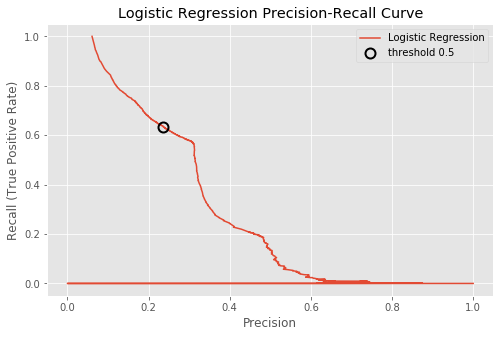

In [129]:
y_pred_prob = gsw_clf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
close_zero = np.argmin(np.abs(thresholds-0.5))

figimp , axpr = plt.subplots(figsize = (8, 5))
# plot precision-recall
axpr.plot(precision, recall, label='Logistic Regression')
axpr.set_xlabel('Precision')
axpr.set_ylabel('Recall (True Positive Rate)')
axpr.set_title('Logistic Regression Precision-Recall Curve')
# plot zero threshold
axpr.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold 0.5", fillstyle="none", c='k', mew=2)
# mew: markeredgewidth
_ = plt.legend()
figimp.savefig(os.path.join(os.pardir, 'reports', 'figures', 'Precision_recall.png'))

In [118]:
import mglearn
mglearn.plots.plot_binary_confusion_matrix()

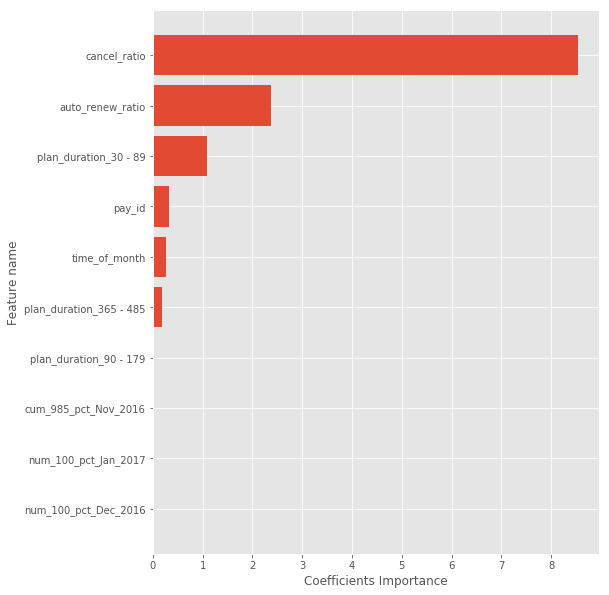

In [130]:
# get column names except target
names = df_full.drop(labels='is_churn', axis = 1).columns

# get coefficient of logistic regression model
l1_coef = gsw_clf.best_estimator_.named_steps['clf'].coef_
# flatten it
l1_coef = np.abs(l1_coef.ravel())
# get indices for sorting in descending order
indsorted = l1_coef.argsort()[::-1]
# apply indices to names and coeff
names = names[indsorted[:10]]
l1_coef = l1_coef[indsorted[:10]]
y_pos = range(len(names))

# make plot
figimp , aximp = plt.subplots(figsize = (8, 10))
aximp.barh(y_pos, l1_coef)
aximp.set_yticks(y_pos)
aximp.set_yticklabels(names)
aximp.set_ylabel('Feature name')
aximp.set_xlabel('Coefficients Importance')
aximp.invert_yaxis()

figimp.savefig(os.path.join(os.pardir, 'reports', 'figures', 'top_features.png'))

### WIthout class weights
(For comparison only)

In [131]:
log_noweights = Pipeline([
                       ('scaler', MinMaxScaler()),
                       ('clf', LogisticRegression(C = 0.003, penalty = 'l1', solver='saga', random_state=7)),
                     ])
scores = cross_validate(log_noweights, X_train, y_train, cv = 5 , scoring='f1', verbose=3, n_jobs=-1)
scores['test_score'].mean()

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   20.5s remaining:   30.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.4s finished


0.07672231374993768

In [132]:
_ = log_noweights.fit(X_train, y_train)

In [133]:
# show classification report
y_pred_lognoweights = log_noweights.predict(X_test)
print(classification_report(y_test, y_pred_lognoweights))

             precision    recall  f1-score   support

      False       0.94      1.00      0.97     92775
       True       0.55      0.07      0.12      6007

avg / total       0.92      0.94      0.92     98782



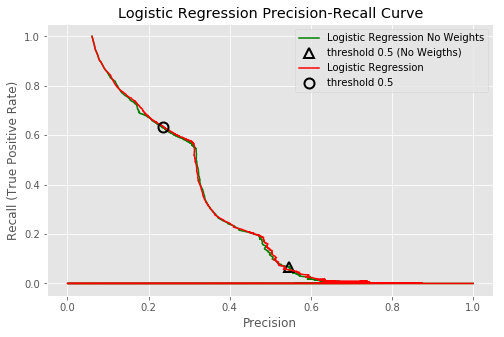

In [134]:
y_pred_prob_lognoweights = log_noweights.predict_proba(X_test)[:,1]
precision_nw, recall_nw, thresholds_nw = precision_recall_curve(y_test, y_pred_prob_lognoweights)
close_zero_nw = np.argmin(np.abs(thresholds_nw-0.5))

figimp_nw , axpr_nw = plt.subplots(figsize = (8, 5))
# plot precision-recall
axpr_nw.plot(precision_nw, recall_nw, label='Logistic Regression No Weights', c='g')
axpr_nw.set_xlabel('Precision')
axpr_nw.set_ylabel('Recall (True Positive Rate)')
axpr_nw.set_title('Logistic Regression Precision-Recall Curve')
# plot zero threshold
axpr_nw.plot(precision_nw[close_zero_nw], recall_nw[close_zero_nw], '^', markersize=10,
         label="threshold 0.5 (No Weigths)", fillstyle="none", c='k', mew=2)

# adding weighted model
axpr_nw.plot(precision, recall, label='Logistic Regression', c='r')
# plot zero threshold
axpr_nw.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold 0.5", fillstyle="none", c='k', mew=2)

_ = plt.legend()

# Random forest

In [135]:
from sklearn.ensemble import RandomForestClassifier

In [136]:
rf_clf = Pipeline([
                       ('scaler', MinMaxScaler()),
                       ('clf', RandomForestClassifier( random_state=7, class_weight='balanced_subsample')),
                    ])

# paramter grid search
parameters = [
              {
              'clf__n_estimators': [100, 200, 300],
              'clf__min_samples_leaf': [2,4,6],
#               'clf__max_depth': [10, 15, 20],
              }
            ]

# set up grid search
gs_rf = GridSearchCV(rf_clf, param_grid = parameters, cv = 5 , scoring='f1' , n_jobs = -1, verbose = 3)

In [ ]:
# perform grid search CV on pipeline
_ = gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 61.1min


In [ ]:
gs_rf.best_params_

In [44]:
# recover estimator from grid search (best estimator as it refit it at the end)
# [t.tree_.max_depth for t in gs_rf.best_estimator_.named_steps['clf'].estimators_]

In [45]:
# show classification report
y_train_pred = gs_rf.predict(X_train)
print(classification_report(y_train, y_train_pred, target_names=["not adopted", "adopted"]))

             precision    recall  f1-score   support

not adopted       1.00      0.97      0.99      8318
    adopted       0.86      0.99      0.92      1282

avg / total       0.98      0.98      0.98      9600



In [46]:
# show classification report
y_pred = gs_rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["not adopted", "adopted"]))

             precision    recall  f1-score   support

not adopted       0.99      0.97      0.98      2080
    adopted       0.85      0.94      0.89       320

avg / total       0.97      0.97      0.97      2400



In [ ]:
# get column names except target
names = df_full.drop(labels='is_churn', axis = 1).columns

# get coefficient of logistic regression model
l1_coef = gs_rf.best_estimator_.named_steps['clf'].feature_importances_
# flatten it
l1_coef = np.abs(l1_coef.ravel())
# get indices for sorting in descending order
indsorted = l1_coef.argsort()[::-1]
# apply indices to names and coeff
names = names[indsorted[:10]]
l1_coef = l1_coef[indsorted[:10]]
y_pos = range(len(names))

# make plot
figimp , aximp = plt.subplots(figsize = (8, 10))
aximp.barh(y_pos, l1_coef)
aximp.set_yticks(y_pos)
aximp.set_yticklabels(names)
aximp.set_ylabel('Feature name')
aximp.set_xlabel('Importance')
aximp.invert_yaxis()

figimp.savefig(os.path.join(os.pardir, 'reports', 'figures', 'top_features_RF.png'))

# Other approach using over-sampling/under-sampling

It takes a long time to perform a grid search, think manys days, maybe a couple of weeks.

#### One step at a time for testing only

In [ ]:
X_scaled = MinMaxScaler().fit_transform(X_train)

In [ ]:
X_up, y_up = SMOTE(ratio = {0 : num_majo, 1: int(num_majo/2)},\
                   k_neighbors = 5, random_state=7, n_jobs=-1).fit_sample(X_scaled, y_train)
# Counter(y_up)

In [ ]:
LogisticRegression(C = 1, penalty = 'l1', solver='saga').fit(X_up, y_up)

#### Single cross-validation

In [ ]:
log_clf_xval = imbPipeline([
                       ('scaler', MinMaxScaler()),
                       ('imb', SMOTE(ratio = {0 : num_majo, 1: int(num_majo/2)}, k_neighbors = 5, random_state=7)),
                       ('clf', LogisticRegression(C = 1, penalty = 'l2', solver='sag')),
                     ])
cross_validate(log_clf_xval, X_train, y_train, cv = 5 , scoring='f1', verbose=3, n_jobs=-1)

#### Testing SMOTE and ENN separately

In [ ]:
smx, smy = SMOTE(ratio = {0 : num_majo, 1: int(num_majo/2)}, k_neighbors = 5, n_jobs=-1).fit_sample(X_scaled, y_train)
Counter(smy)

In [ ]:
ennx, enny = EditedNearestNeighbours(ratio = 'all', kind_sel = 'mode', n_neighbors = 3, n_jobs=-1).fit_sample(smx, smy)
Counter(enny)

#### Testing SOMTE and ENN together (ratio in SMOTEENN is not used, SMOTE comes first then ENN with their respective ratio)

In [ ]:
sm = SMOTE(ratio = {0 : num_majo, 1: int(num_majo/2)}, k_neighbors = 5, n_jobs=-1)
enn = EditedNearestNeighbours(ratio = 'all', kind_sel = 'mode', n_neighbors = 3, n_jobs=-1)
Xou, you = SMOTEENN(random_state=7, smote=sm, enn = enn).fit_sample(X_scaled, y_train)

In [ ]:
Counter(you)

#### Full grid search using over-sampling (SMOTE) and under-sampling (ENN)

**Warnings** : it will takes days to run this grid search

In [ ]:
# # cache transformer results for faster grid search
# from tempfile import mkdtemp
# cachedir = mkdtemp(dir=os.path.join(os.pardir))

In [ ]:
log_clf = imbPipeline([
                       ('scaler', MinMaxScaler()),
                       ('imbup', SMOTE(random_state=7)),
                       ('imbdown', EditedNearestNeighbours(random_state=7)),
                       ('clf', LogisticRegression(random_state=7))),
                     ])

# paramter grid search
parameters = [
              {
              'imbup__ratio': [{0 : num_majo, 1: int(num_majo/2)},
                             {0 : num_majo, 1: int(num_majo/3)},
                             {0 : num_majo, 1: int(num_majo/4)}],
              'imbup__k_neighbors': [5, 6, 7],
              'imbdown__ratio': ['all'],
              'imbdown__n_neighbors': [2, 3, 4],
              'imbdown__kind_sel': ['all', 'mode'],
              'clf__C': [0.1, 0.3, 1],
              'clf__penalty': ['l1'],
              'clf__solver': ['saga'],
              }
              {
              'imbup__ratio': [{0 : num_majo, 1: int(num_majo/2)},
                             {0 : num_majo, 1: int(num_majo/3)},
                             {0 : num_majo, 1: int(num_majo/4)}],
              'imbup__k_neighbors': [5, 6, 7],
              'imbdown__ratio': ['all'],
              'imbdown__n_neighbors': [2, 3, 4],
              'imbdown__kind_sel': ['all', 'mode'],
              'clf__C': [0.1, 0.3, 1],
              'clf__penalty': ['l2'],
              'clf__solver': ['sag'],
              }
            ]

# set up grid search
# NOTE: during xval, it will default to stratified kfold for classifiers (f1 score)
gs_clf = GridSearchCV(log_clf, param_grid = parameters, cv = 5 , scoring='f1' , n_jobs = -1, verbose = 3)

In [ ]:
# perform grid search CV on pipeline
gs_clf.fit(X_train, y_train)

In [ ]:
# from shutil import rmtree
# # Clear the cache directory when you don't need it anymore
# rmtree(cachedir)

In [ ]:
# ROC_AUC is not ideal for class imbalance as it doesn't focus on the minority class
y_pred_prob = gsw_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
close_zero = np.argmin(np.abs(thresholds-0.5))

figimp , axroc = plt.subplots(figsize = (8, 5))
# diagonal
axroc.plot([0, 1], [0, 1], 'k--')
# plot ROC
axroc.plot(fpr, tpr, label='Logistic Regression')
axroc.set_xlabel('False Positive Rate')
axroc.set_ylabel('True Positive Rate (recall)')
axroc.set_title('Logistic Regression ROC Curve')
# plot zero threshold
axroc.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold 0.5", fillstyle="none", c='k', mew=2)
_ = plt.legend()